In [1]:
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
from glob import glob
import cv2 
import time
import datetime
from tqdm import tqdm
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.environ['KAGGLE_USERNAME'] = "muhammadalbarbary" # username from the json file
os.environ['KAGGLE_KEY'] = "4a7ed3752a8cfdb1dd648099acea55c9" # key from the json file
!kaggle competitions download -c diabetic-retinopathy-detection -f train.zip.002
!kaggle competitions download -c diabetic-retinopathy-detection -f trainLabels.csv.zip
! unzip "trainLabels.csv.zip"
! unzip "train.zip.002.zip"
!apt install p7zip-full -y
!7z x train.zip.002 #extract
!ls train | wc -l #print number of images
!ls train #print paths

100% 7.80G/7.81G [00:59<00:00, 167MB/s]
100% 7.81G/7.81G [00:59<00:00, 142MB/s]
  0% 0.00/69.4k [00:00<?, ?B/s]
100% 69.4k/69.4k [00:00<00:00, 1.97MB/s]
Archive:  trainLabels.csv.zip
  inflating: trainLabels.csv         
Archive:  train.zip.002.zip
  inflating: train.zip.002           
Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 8388608000 bytes (8000 MiB)

Extracting archive: train.zip.002
  3% 256 Open

In [2]:
base_image_dir = "/content/train"
retina_df = pd.read_csv("/content/trainLabels.csv")
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,
                                                         '{}.jpeg'.format(x)))
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(10)

8394 images found of 35126 total


,image,level,PatientId,path,exists,eye,level_cat
20519,25878_right,0,25878,/content/train/25878_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
18474,23269_left,0,23269,/content/train/23269_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
20308,25615_left,2,25615,/content/train/25615_left.jpeg,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
16090,20169_left,2,20169,/content/train/20169_left.jpeg,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
20295,25597_right,2,25597,/content/train/25597_right.jpeg,True,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"
212,241_left,0,241,/content/train/241_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
17159,21539_right,0,21539,/content/train/21539_right.jpeg,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
19942,25148_left,0,25148,/content/train/25148_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1830,2284_left,0,2284,/content/train/2284_left.jpeg,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2130,2648_left,2,2648,/content/train/2648_left.jpeg,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"


New Data Size: 5000 Old Size: 8394


,PatientId,exists,eye,image,level_cat,path
level,,,,,,
0,1000,1000,1000,1000,1000,1000
1,1000,1000,1000,1000,1000,1000
2,1000,1000,1000,1000,1000,1000
3,1000,1000,1000,1000,1000,1000
4,1000,1000,1000,1000,1000,1000


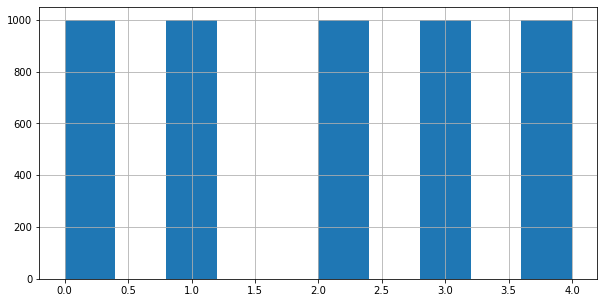

In [3]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df
train_df = balance_data(1000,retina_df) # oversample such that all classes have the same number of images as the maximum
retina_df.pivot_table(index='level', aggfunc=len)
train_df.pivot_table(index='level', aggfunc=len)


In [4]:
def get_label_and_image(path): 
  name= path.split('/')[-1].split('.')[0]
  label=train_df["level_cat"].loc[train_df['image'] == name].values[0]
  image=plt.imread(path)
  return image,label #returns (L, W, 3) np array (RGB) and Int Label

In [ ]:
IMAGE_SIZE=(299,299)
dataset={"image":[],
            "label":[]}
paths=train_df["path"]
for counter in range(len(paths)):
  image,label=get_label_and_image(paths[counter])
  dataset["image"].append(cv2.resize(image, IMAGE_SIZE))
  dataset["label"].append(label)
  print(f"{counter}/{len(paths)}")

0/5000
1/5000
2/5000
3/5000
4/5000
5/5000
6/5000
7/5000
8/5000
9/5000
10/5000
11/5000
12/5000
13/5000
14/5000
15/5000
16/5000
17/5000
18/5000
19/5000
20/5000
21/5000
22/5000
23/5000
24/5000
25/5000
26/5000
27/5000
28/5000
29/5000
30/5000
31/5000
32/5000
33/5000
34/5000
35/5000
36/5000
37/5000
38/5000
39/5000
40/5000
41/5000
42/5000
43/5000
44/5000
45/5000
46/5000
47/5000
48/5000
49/5000
50/5000
51/5000
52/5000
53/5000
54/5000
55/5000
56/5000
57/5000
58/5000
59/5000
60/5000
61/5000
62/5000
63/5000
64/5000
65/5000
66/5000
67/5000
68/5000
69/5000
70/5000
71/5000
72/5000
73/5000
74/5000
75/5000
76/5000
77/5000
78/5000
79/5000
80/5000
81/5000
82/5000
83/5000
84/5000
85/5000
86/5000
87/5000
88/5000
89/5000
90/5000
91/5000
92/5000
93/5000
94/5000
95/5000
96/5000
97/5000
98/5000
99/5000
100/5000
101/5000
102/5000
103/5000
104/5000
105/5000
106/5000
107/5000
108/5000
109/5000
110/5000
111/5000
112/5000
113/5000
114/5000
115/5000
116/5000
117/5000
118/5000
119/5000
120/5000
121/5000
122/5000
123

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(np.asarray(dataset["image"]), np.asarray(dataset["label"]), test_size=0.2, random_state=42)#,stratify=np.asarray(dataset["label"]))
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)#,stratify=test_labels)
print(train_images.shape,train_labels.shape)
print(val_images.shape,val_labels.shape)
print(test_images.shape,test_labels.shape)
print(np.unique(train_labels.argmax(1),return_counts=True))
print(np.unique(val_labels.argmax(1),return_counts=True))
print(np.unique(test_labels.argmax(1),return_counts=True))

In [ ]:
#data visualization
f, axarr = plt.subplots(2,2, figsize=(10, 10))
randidx=[np.random.randint(0,train_images.shape[0]) for i in range (4)]

axarr[0,0].imshow(train_images[randidx[0]])
axarr[0,0].set_title("level:"+ str(train_labels[randidx[0]].argmax(0)));  

axarr[0,1].imshow(train_images[randidx[1]])
axarr[0,1].set_title("level:"+ str(train_labels[randidx[1]].argmax(0))); 

axarr[1,0].imshow(train_images[randidx[2]])
axarr[1,0].set_title("level:"+ str(train_labels[randidx[2]].argmax(0)));  

axarr[1,1].imshow(train_images[randidx[3]])
axarr[1,1].set_title("level:"+ str(train_labels[randidx[3]].argmax(0)));  

In [ ]:
ptm = InceptionResNetV2(
        input_shape = IMAGE_SIZE+(3,),
        weights = 'imagenet',
        include_top = True,
        pooling='max',
)
ptm.trainable = True
K = 5 #number of labels
x = Flatten()(ptm.output)
x = Dense(K, activation = 'softmax')(x)
model = Model(inputs = ptm.input , outputs = x)

In [ ]:
model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

In [ ]:
# custom_early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=19, 
#     restore_best_weights=False)

# save_checkpoint_cb= callbacks.ModelCheckpoint(
#                       filepath='/content/drive/MyDrive/Biometrics Project/IRCP/IRCP', 
#                       save_freq='epoch', verbose=0,save_weights_only=True)
history=model.fit(
        x=train_images,
        y=train_labels,
        validation_data = (val_images,val_labels),
        epochs = 30,
        shuffle=True,
        # batch_size=10
)

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights("/content/drive/MyDrive/Diabetic Retinopathy Detection/InceptionResNet_Weights")

In [ ]:
model.evaluate(test_images,test_labels)